In [1]:
from graphframes import *
from pyspark import *
from pyspark.sql import *


# Creating GraphFrames

Users can create GraphFrames from vertex and edge DataFrames.

* Vertex DataFrame: A vertex DataFrame should contain a special column named “id” which specifies unique IDs for each vertex in the graph.

* Edge DataFrame: An edge DataFrame should contain two special columns: “src” (source vertex ID of edge) and “dst” (destination vertex ID of edge).


In [2]:

spark = SparkSession.builder.appName('fun').getOrCreate()

vertices = spark.createDataFrame([('1', 'Carter', 'Derrick', 50), 
                                  ('2', 'May', 'Derrick', 26),
                                 ('3', 'Mills', 'Jeff', 80),
                                  ('4', 'Hood', 'Robert', 65),
                                  ('5', 'Banks', 'Mike', 93),
                                 ('98', 'Berg', 'Tim', 28),
                                 ('99', 'Page', 'Allan', 16)],
                                 ['id', 'name', 'firstname', 'age'])
edges = spark.createDataFrame([('1', '2', 'friend'), 
                               ('2', '1', 'friend'),
                              ('3', '1', 'friend'),
                              ('1', '3', 'friend'),
                               ('2', '3', 'follows'),
                               ('3', '4', 'friend'),
                               ('4', '3', 'friend'),
                               ('5', '3', 'friend'),
                               ('3', '5', 'friend'),
                               ('4', '5', 'follows'),
                              ('98', '99', 'friend'),
                              ('99', '98', 'friend')],
                              ['src', 'dst', 'type'])
g = GraphFrame(vertices, edges)
## Take a look at the DataFrames
g.vertices.show()
g.edges.show()
## Check the number of edges of each vertex
g.degrees.show()

+---+------+---------+---+
| id|  name|firstname|age|
+---+------+---------+---+
|  1|Carter|  Derrick| 50|
|  2|   May|  Derrick| 26|
|  3| Mills|     Jeff| 80|
|  4|  Hood|   Robert| 65|
|  5| Banks|     Mike| 93|
| 98|  Berg|      Tim| 28|
| 99|  Page|    Allan| 16|
+---+------+---------+---+

+---+---+-------+
|src|dst|   type|
+---+---+-------+
|  1|  2| friend|
|  2|  1| friend|
|  3|  1| friend|
|  1|  3| friend|
|  2|  3|follows|
|  3|  4| friend|
|  4|  3| friend|
|  5|  3| friend|
|  3|  5| friend|
|  4|  5|follows|
| 98| 99| friend|
| 99| 98| friend|
+---+---+-------+

+---+------+
| id|degree|
+---+------+
|  3|     7|
| 98|     2|
| 99|     2|
|  5|     3|
|  1|     4|
|  4|     3|
|  2|     3|
+---+------+



In [3]:
g.outDegrees.show()
g.inDegrees.show()

+---+---------+
| id|outDegree|
+---+---------+
|  3|        3|
| 98|        1|
| 99|        1|
|  5|        1|
|  1|        2|
|  4|        2|
|  2|        2|
+---+---------+

+---+--------+
| id|inDegree|
+---+--------+
|  3|       4|
| 98|       1|
| 99|       1|
|  5|       2|
|  1|       2|
|  4|       1|
|  2|       1|
+---+--------+



In [4]:
vertexInDegrees = g.inDegrees

In [5]:
type(vertexInDegrees)


pyspark.sql.dataframe.DataFrame

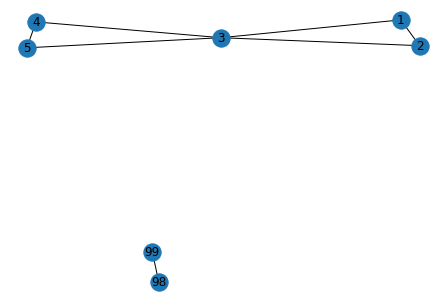

In [6]:
import networkx as nx
gp = nx.from_pandas_edgelist(edges.toPandas(),'src','dst')
nx.draw(gp, with_labels = True)

In [7]:
!pip install networkx

You should consider upgrading via the '/opt/mistsys/ds_incubator/venv/bin/python3 -m pip install --upgrade pip' command.


In [8]:
copy = edges
from pyspark.sql.functions import udf
@udf("string")
def to_undir(src, dst):
    if src >= dst:
        return 'Delete'
    else : 
        return 'Keep'

copy =copy.withColumn('undir', to_undir(copy.src, copy.dst))\
.filter('undir == "Keep"').drop('undir')
    
# copy.withColumn('undir', to_undir(copy.src, copy.dst))\
# .filter('undir == "Keep"').drop('undir').show()
## for efficiency, it's better to avoid udf functions where possible ## and use built-in pyspark.sql.functions instead.

In [9]:
edges.show()
copy.show()


+---+---+-------+
|src|dst|   type|
+---+---+-------+
|  1|  2| friend|
|  2|  1| friend|
|  3|  1| friend|
|  1|  3| friend|
|  2|  3|follows|
|  3|  4| friend|
|  4|  3| friend|
|  5|  3| friend|
|  3|  5| friend|
|  4|  5|follows|
| 98| 99| friend|
| 99| 98| friend|
+---+---+-------+

+---+---+-------+
|src|dst|   type|
+---+---+-------+
|  1|  2| friend|
|  1|  3| friend|
|  2|  3|follows|
|  3|  4| friend|
|  3|  5| friend|
|  4|  5|follows|
| 98| 99| friend|
+---+---+-------+



In [10]:
dir(edges)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattr__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_collectAsArrow',
 '_jcols',
 '_jdf',
 '_jmap',
 '_jseq',
 '_lazy_rdd',
 '_repr_html_',
 '_sc',
 '_schema',
 '_sort_cols',
 '_support_repr_html',
 'agg',
 'alias',
 'approxQuantile',
 'cache',
 'checkpoint',
 'coalesce',
 'colRegex',
 'collect',
 'columns',
 'corr',
 'count',
 'cov',
 'createGlobalTempView',
 'createOrReplaceGlobalTempView',
 'createOrReplaceTempView',
 'createTempView',
 'crossJoin',
 'crosstab',
 'cube',
 'describe',
 'distinct',
 'drop',
 'dropDuplicates',
 'drop_duplicates',
 'dropna',
 'dtypes',
 'exceptAll',
 'explain',
 'fillna',
 'filter',
 'first',
 'foreach',
 'f

In [11]:
g.vertices.filter("age > 30").show()
g.inDegrees.filter("inDegree >= 2").sort("inDegree", ascending=False).show()
g.edges.filter('type == "friend"')

+---+------+---------+---+
| id|  name|firstname|age|
+---+------+---------+---+
|  1|Carter|  Derrick| 50|
|  3| Mills|     Jeff| 80|
|  4|  Hood|   Robert| 65|
|  5| Banks|     Mike| 93|
+---+------+---------+---+

+---+--------+
| id|inDegree|
+---+--------+
|  3|       4|
|  5|       2|
|  1|       2|
+---+--------+



DataFrame[src: string, dst: string, type: string]

In [12]:
# dir(g)

sc.setCheckpointDir('graphframes_cps')

In [13]:
g.connectedComponents().show()


+---+------+---------+---+------------+
| id|  name|firstname|age|   component|
+---+------+---------+---+------------+
|  1|Carter|  Derrick| 50|154618822656|
|  2|   May|  Derrick| 26|154618822656|
|  3| Mills|     Jeff| 80|154618822656|
|  4|  Hood|   Robert| 65|154618822656|
|  5| Banks|     Mike| 93|154618822656|
| 98|  Berg|      Tim| 28|317827579904|
| 99|  Page|    Allan| 16|317827579904|
+---+------+---------+---+------------+



In [14]:
g.find("(a)-[e]->(b); (b)-[e2]->(a)").show()

+--------------------+----------------+--------------------+----------------+
|                   a|               e|                   b|              e2|
+--------------------+----------------+--------------------+----------------+
| [98, Berg, Tim, 28]|[98, 99, friend]|[99, Page, Allan,...|[99, 98, friend]|
|[2, May, Derrick,...|  [2, 1, friend]|[1, Carter, Derri...|  [1, 2, friend]|
|[99, Page, Allan,...|[99, 98, friend]| [98, Berg, Tim, 28]|[98, 99, friend]|
|[3, Mills, Jeff, 80]|  [3, 5, friend]|[5, Banks, Mike, 93]|  [5, 3, friend]|
|[1, Carter, Derri...|  [1, 3, friend]|[3, Mills, Jeff, 80]|  [3, 1, friend]|
|[3, Mills, Jeff, 80]|  [3, 1, friend]|[1, Carter, Derri...|  [1, 3, friend]|
|[5, Banks, Mike, 93]|  [5, 3, friend]|[3, Mills, Jeff, 80]|  [3, 5, friend]|
|[4, Hood, Robert,...|  [4, 3, friend]|[3, Mills, Jeff, 80]|  [3, 4, friend]|
|[1, Carter, Derri...|  [1, 2, friend]|[2, May, Derrick,...|  [2, 1, friend]|
|[3, Mills, Jeff, 80]|  [3, 4, friend]|[4, Hood, Robert,...|  [4

In [15]:
mutualFriends = g.find("(a)-[]->(b); (b)-[]->(c); (c)-[]->(b); (b)-[]->(a)").dropDuplicates()
mutualFriends.show()

+--------------------+--------------------+--------------------+
|                   a|                   b|                   c|
+--------------------+--------------------+--------------------+
|[4, Hood, Robert,...|[3, Mills, Jeff, 80]|[4, Hood, Robert,...|
|[3, Mills, Jeff, 80]|[1, Carter, Derri...|[2, May, Derrick,...|
|[5, Banks, Mike, 93]|[3, Mills, Jeff, 80]|[1, Carter, Derri...|
|[4, Hood, Robert,...|[3, Mills, Jeff, 80]|[1, Carter, Derri...|
|[3, Mills, Jeff, 80]|[1, Carter, Derri...|[3, Mills, Jeff, 80]|
|[5, Banks, Mike, 93]|[3, Mills, Jeff, 80]|[5, Banks, Mike, 93]|
|[5, Banks, Mike, 93]|[3, Mills, Jeff, 80]|[4, Hood, Robert,...|
|[1, Carter, Derri...|[2, May, Derrick,...|[1, Carter, Derri...|
|[1, Carter, Derri...|[3, Mills, Jeff, 80]|[4, Hood, Robert,...|
|[2, May, Derrick,...|[1, Carter, Derri...|[3, Mills, Jeff, 80]|
|[1, Carter, Derri...|[3, Mills, Jeff, 80]|[5, Banks, Mike, 93]|
|[1, Carter, Derri...|[3, Mills, Jeff, 80]|[1, Carter, Derri...|
|[99, Page, Allan,...| [9

In [16]:
# mutualFriends
mutualFriends.filter('a.id == 2 and c.id == 3').show()

+--------------------+--------------------+--------------------+
|                   a|                   b|                   c|
+--------------------+--------------------+--------------------+
|[2, May, Derrick,...|[1, Carter, Derri...|[3, Mills, Jeff, 80]|
+--------------------+--------------------+--------------------+



# motifs finding

In [17]:
motifs = g.find("(a)-[e]->(b); (b)-[e2]->(a)")
motifs.show()

# More complex queries can be expressed by applying filters.
motifs.filter("b.age > 30").show()

+--------------------+----------------+--------------------+----------------+
|                   a|               e|                   b|              e2|
+--------------------+----------------+--------------------+----------------+
| [98, Berg, Tim, 28]|[98, 99, friend]|[99, Page, Allan,...|[99, 98, friend]|
|[2, May, Derrick,...|  [2, 1, friend]|[1, Carter, Derri...|  [1, 2, friend]|
|[99, Page, Allan,...|[99, 98, friend]| [98, Berg, Tim, 28]|[98, 99, friend]|
|[3, Mills, Jeff, 80]|  [3, 5, friend]|[5, Banks, Mike, 93]|  [5, 3, friend]|
|[1, Carter, Derri...|  [1, 3, friend]|[3, Mills, Jeff, 80]|  [3, 1, friend]|
|[3, Mills, Jeff, 80]|  [3, 1, friend]|[1, Carter, Derri...|  [1, 3, friend]|
|[5, Banks, Mike, 93]|  [5, 3, friend]|[3, Mills, Jeff, 80]|  [3, 5, friend]|
|[4, Hood, Robert,...|  [4, 3, friend]|[3, Mills, Jeff, 80]|  [3, 4, friend]|
|[1, Carter, Derri...|  [1, 2, friend]|[2, May, Derrick,...|  [2, 1, friend]|
|[3, Mills, Jeff, 80]|  [3, 4, friend]|[4, Hood, Robert,...|  [4

In [18]:
from graphframes.examples import Graphs
g = Graphs(sqlContext).friends()  # Get example graph

# Search for pairs of vertices with edges in both directions between them.
motifs = g.find("(a)-[e]->(b); (b)-[e2]->(a)")
motifs.show()

# More complex queries can be expressed by applying filters.
motifs.filter("b.age > 30").show()

+----------------+--------------+----------------+--------------+
|               a|             e|               b|            e2|
+----------------+--------------+----------------+--------------+
|[c, Charlie, 30]|[c, b, follow]|    [b, Bob, 36]|[b, c, follow]|
|    [b, Bob, 36]|[b, c, follow]|[c, Charlie, 30]|[c, b, follow]|
+----------------+--------------+----------------+--------------+

+----------------+--------------+------------+--------------+
|               a|             e|           b|            e2|
+----------------+--------------+------------+--------------+
|[c, Charlie, 30]|[c, b, follow]|[b, Bob, 36]|[b, c, follow]|
+----------------+--------------+------------+--------------+



In [19]:
# from pyspark.sql.functions import col, lit, when
# from pyspark.sql.types import IntegerType
# from graphframes.examples import Graphs

# from functools import reduce

chain4 = g.find("(a)-[ab]->(b); (b)-[bc]->(c); (c)-[cd]->(d)")

# Query on sequence, with state (cnt)
#  (a) Define method for updating state given the next element of the motif.
sumFriends =\
  lambda cnt,relationship: when(relationship == "friend", cnt+1).otherwise(cnt)
#  (b) Use sequence operation to apply method to sequence of elements in motif.
#      In this case, the elements are the 3 edges.
condition =\
  reduce(lambda cnt,e: sumFriends(cnt, col(e).relationship), ["ab", "bc", "cd"], lit(0))
#  (c) Apply filter to DataFrame.
chainWith2Friends2 = chain4.where(condition >= 2)
chainWith2Friends2.show()

NameError: name 'reduce' is not defined

In [ ]:
dir(g)

In [ ]:
from graphframes.examples import Graphs

# Drop isolated vertices (users) which are not contained in any edges (relationships).
g1 = g.filterVertices("age > 30").filterEdges("relationship = 'friend'").dropIsolatedVertices()

In [ ]:
from graphframes.examples import Graphs
g = Graphs(sqlContext).friends()  # Get example graph

# Select subgraph based on edges "e" of type "follow"
# pointing from a younger user "a" to an older user "b".
paths = g.find("(a)-[e]->(b)")\
  .filter("e.relationship = 'follow'")\
  .filter("a.age < b.age")
# "paths" contains vertex info. Extract the edges.
e2 = paths.select("e.src", "e.dst", "e.relationship")
# In Spark 1.5+, the user may simplify this call:
#  val e2 = paths.select("e.*")

# Construct the subgraph
g2 = GraphFrame(g.vertices, e2)

In [ ]:
g = Graphs(sqlContext).friends()  # Get example graph

# Search from "Esther" for users of age < 32.
paths = g.bfs("name = 'Esther'", "age < 32")
paths.show()

# Specify edge filters or max path lengths.
g.bfs("name = 'Esther'", "age < 32",\
  edgeFilter="relationship != 'friend'", maxPathLength=3)

In [ ]:
g.triangleCount().show()

In [ ]:
pr = g.pageRank(resetProbability=0.15, tol=0.01)
## look at the pagerank score for every vertex
pr.vertices.show()
## look at the weight of every edge
pr.edges.show()

In [ ]:

from graphframes.examples import Graphs
g = Graphs(sqlContext).friends()  # Get example graph

# Search from "Esther" for users of age < 32.
paths = g.bfs("name = 'Esther'", "age < 32")
paths.show()

# Specify edge filters or max path lengths.
g.bfs("name = 'Esther'", "age < 32",\
  edgeFilter="relationship != 'friend'", maxPathLength=3)

In [ ]:
#

In [ ]:
from pyspark.sql import SQLContext
from pyspark import SparkContext

# # Create DataFrames from HIVE query
# v=sqlCtx.sql("select  id, name, total_seconds from my_schema.nodes")
# e=sqlCtx.sql("select src, dst, relationship from my_schema.edges")

# Create DataFrames manually for testing purposes
v = sqlContext.createDataFrame([
    ("A", "ARON"  ,350 ),
    ("B", "BILL"  ,360 ),
    ("C", "CLAIR" ,195 ),
    ("D", "DANIEL",90),
    ("E", "ERIC"  ,90),
    ("F", "FRANK" ,215 ),
    ("G", "GRAHAM",30 ),
    ("H", "HENRY" ,25 ),
    ("I", "INNA"  ,25 ),
    ("J", "JEN"   ,20 )
], ["id", "name", "total_seconds"])

e=sqlContext.createDataFrame([
    ("A", "B", 60),
    ("B", "A", 50),
    ("A", "C", 50),
    ("C", "A", 100),
    ("A", "D", 90),
    ("C", "I", 25),
    ("C", "J", 20),
    ("B", "F", 50),
    ("F", "B", 110),
    ("F", "G", 30),
    ("F", "H", 25),
    ("B", "E", 90)
],["src","dst","relationship"])


g2 = GraphFrame(v, e)
## Take a look at the DataFrames
g2.vertices.show()
g2.edges.show()
## Check the number of edges of each vertex
g2.degrees.show()

In [ ]:
result = g.connectedComponents()
result.select("id", "component").orderBy("component").show()

In [ ]:
results = g.shortestPaths(landmarks=["a", "d"])
results.select("id", "distances").show()

In [ ]:
results = g.triangleCount()
results.select("id", "count").show()
